# Machine learning: Boosting de Algoritmos

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
from pickle import dump
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score

## Datasets sin feature selection

In [2]:
BASE_PATH = "../data/processed"
TRAIN_PATHS = [
    "X_train_con_outliers.xlsx",
    "X_train_sin_outliers.xlsx",
]
TRAIN_DATASETS = []
for path in TRAIN_PATHS:
    TRAIN_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

TEST_PATHS = [
    "X_test_con_outliers.xlsx",
    "X_test_sin_outliers.xlsx",
]
TEST_DATASETS = []
for path in TEST_PATHS:
    TEST_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

y_train = pd.read_excel(f"{BASE_PATH}/y_train.xlsx")
y_test = pd.read_excel(f"{BASE_PATH}/y_test.xlsx")

In [10]:
results = []
models=[]

for index, dataset in enumerate(TRAIN_DATASETS):
    model = XGBClassifier(random_state = 42)
    model.fit(dataset, y_train)
    models.append(model)
    
    y_pred_train = model.predict(dataset)
    y_pred_test = model.predict(TEST_DATASETS[index])

    results.append(
        {
            "train": accuracy_score(y_train, y_pred_train),
            "test": accuracy_score(y_test, y_pred_test)
        }
    )

results

[{'train': 1.0, 'test': 0.8571428571428571},
 {'train': 1.0, 'test': 0.8636363636363636}]

Hay overfitting, los accuracies son mejores que las del decision tree pero peores que las del random forest

## Cargando el dataset con feature selection

In [11]:
train_data = pd.read_csv("../data/processed/clean_train_con_outliers.csv")
test_data = pd.read_csv("../data/processed/clean_test_con_outliers.csv")

X_train = train_data.drop(["Outcome"], axis = 1)
y_train = train_data["Outcome"]
X_test = test_data.drop(["Outcome"], axis = 1)
y_test = test_data["Outcome"]

In [12]:
model = XGBClassifier(random_state = 42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [13]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"Train: {accuracy_score(y_train, y_pred_train)}")
print(f"Test: {accuracy_score(y_test, y_pred_test)}")

Train: 1.0
Test: 0.8636363636363636


Es exactamente el mismo valor que el del decision tree optimizado, peor que el del random forest

## Hiperparametrización

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_lambda': [0, 1, 10],
    'reg_alpha': [0, 0.1, 1]
}

grid = GridSearchCV(model, param_grid, scoring = "accuracy", cv = 5, njobs=1)
grid

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints...
                                     max_leaves=None, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'reg_alpha': [0, 0.1, 1], 'reg_lambda': [0, 1, 10],
                         'subsample': [0.8, 1]},
             scoring='accuracy')

In [23]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid.best_params_}")

Mejores hiperparámetros: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1}


In [27]:
model = XGBClassifier(
    max_depth=4,             
    min_child_weight=3,      
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=70,         
    learning_rate=0.05,      
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"Train: {accuracy_score(y_train, y_pred_train)}")
print(f"Test: {accuracy_score(y_test, y_pred_test)}")

Train: 0.9429967426710097
Test: 0.8701298701298701


Peor resultado que el decision-tree y similar al del random forest

In [20]:
dump(model, open("../models/boosting_classifier_42.sav", "wb"))

## Análisis
En este caso el modelo que ha ofrecido mejores resultados a igualdad de dataset (con outliers y con feature selection=5) ha sido el boosting pero los resultados son muy similares. Creo que es posible que con el EDA realizado el techo de acierto esté sobre un 87% y por eso resulta muy pequeña la diferencia con el dataset con feature selection. 

Me ha resultado imposible optimizar la predicción del random forest con feature selection previa.

Si comparamos sin feature selection, el mejor ha sido el random forest, seguido del boosting de algoritmos y con el decision tree en último lugar.



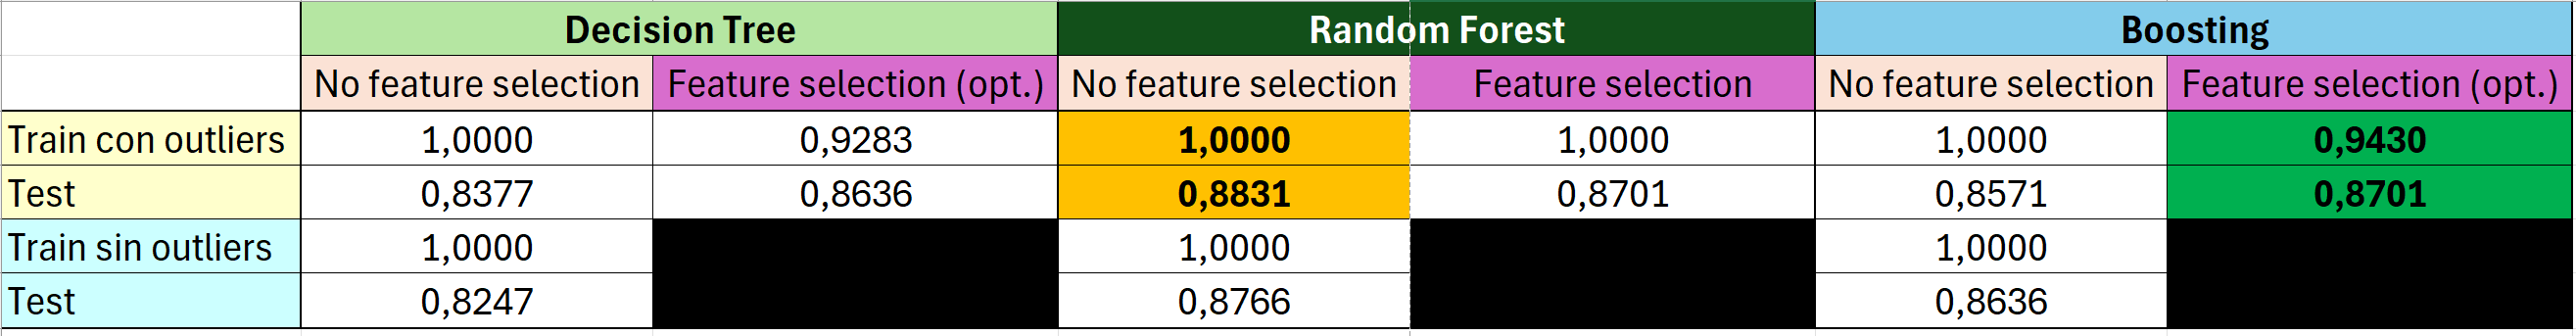